# <a id='toc1_'></a>[EDA with KMeans Clustering](#toc0_)

In this notebook, I’ll be exploring the full Sepsis dataset using unsupervised clustering. I’ll determine a good value for K and do a quantitative analysis of the resulting clusters.

The two medical centers in the data will be dealt with separately here. This should preserve any differences inherent in their location. For exploration purposes, this notebook deals
only with the Leipzig center, which is by far the larger center in terms of the number of data points. 

This notebook also uses the default labels from the publishers of the data. That is, any case labeled as Sepsis reflects a blood test from within 6 hours of ICU admission with a Sepsis diagnosis. 

**Table of contents**<a id='toc0_'></a>    
- [EDA with KMeans Clustering](#toc1_)    
- [Module and Data Imports](#toc2_)    
- [Prep and Scale Data](#toc3_)    
- [Elbow Methods for K selection](#toc4_)    
  - [Inertia / Distortion](#toc4_1_)    
  - [Davies Bouldin Score](#toc4_2_)    
  - [Calinski harabasz - Leipzig](#toc4_3_)    
  - [Calinski harabasz - Greifswald](#toc4_4_)    
  - [Silhouette](#toc4_5_)    
- [Kmeans 2 clusters - Leipzig](#toc5_)    
  - [Train Model](#toc5_1_)    
  - [Extract and append cluster labels](#toc5_2_)    
  - [Label Analysis for k = 2](#toc5_3_)    
- [KMeans - Sample Weight Adjustment](#toc6_)    
- [Feature Analysis for k = 2](#toc7_)    
  - [Spider Chart for CBC Features](#toc7_1_)    
  - [Spider Chart for CBC Features + Sepsis](#toc7_2_)    
- [Individual Feature Comparisions](#toc8_)    
  - [HGB comparison](#toc8_1_)    
  - [MCV comparison](#toc8_2_)    
  - [PLT comparison](#toc8_3_)    
  - [RBC comparison](#toc8_4_)    
  - [WBC comparison](#toc8_5_)    
  - [Feature comparisons Summary](#toc8_6_)    
- [Summary](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Module and Data Imports](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import mode

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score


from sklearn.cluster import KMeans


from yellowbrick.cluster import KElbowVisualizer

In [2]:
leipzig_full_data_df = pd.read_csv('../data/processed/leipzig_full_data.csv', index_col=0)
greifswald_full_data_df = pd.read_csv('../data/processed/greifswald_full_data.csv', index_col=0)

In [3]:
leipzig_full_data_df.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu
438077,1,79,M,Control,Leipzig,Training,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,Control,NaN
438078,2,35,M,Control,Leipzig,Training,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,Control,NaN
438079,3,47,W,Control,Leipzig,Training,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,Control,NaN
438080,4,28,M,Control,Leipzig,Training,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,Control,NaN
438081,5,63,W,Control,Leipzig,Training,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,Control,NaN


In [4]:
leipzig_full_data_df['Time'].info()

<class 'pandas.core.series.Series'>
Index: 1381358 entries, 438077 to 1819434
Series name: Time
Non-Null Count    Dtype  
--------------    -----  
1381358 non-null  float64
dtypes: float64(1)
memory usage: 21.1 MB


In [5]:
#Reset the index for Leipzig so that it's its own data set. 
leipzig_full_data_df = leipzig_full_data_df.reset_index(drop=True)

In [6]:
leipzig_full_data_df.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu
0,1,79,M,Control,Leipzig,Training,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,Control,NaN
1,2,35,M,Control,Leipzig,Training,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,Control,NaN
2,3,47,W,Control,Leipzig,Training,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,Control,NaN
3,4,28,M,Control,Leipzig,Training,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,Control,NaN
4,5,63,W,Control,Leipzig,Training,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,Control,NaN


In [7]:
greifswald_full_data_df.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu
0,1,25,W,Control,Greifswald,Validation,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,Control,NaN
1,2,75,M,Control,Greifswald,Validation,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,Control,NaN
2,4,69,M,Control,Greifswald,Validation,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,Control,NaN
3,5,88,W,Control,Greifswald,Validation,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,Control,NaN
4,6,75,M,Control,Greifswald,Validation,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,Control,NaN


# <a id='toc3_'></a>[Prep and Scale Data](#toc0_)

To prep the data for K-means clustering, I’ll remove most of the categorical columns along with the blood test columns that don’t contain CBC-related values (CRP and PCT). These columns have numerous NaN values that K-means won’t like.

The model done by the previous group used Age, Sex, and the CBC blood test features for their model. I'll be using the same thing here. 

In [8]:
cols_to_drop = ['Id','Diagnosis','Center','Set','Time','SecToIcu','CRP','PCT','HrsToIcu', 'Label']

leipzig_full_data_num = leipzig_full_data_df.drop(columns = cols_to_drop)
greifswald_full_data_num = greifswald_full_data_df.drop(columns = cols_to_drop)


In [9]:
leipzig_full_data_num.head()

,Age,Sex,HGB,MCV,PLT,RBC,WBC
0,79,M,8.1,86.0,167.0,4.36,7.3
1,35,M,10.6,79.9,199.0,6.02,4.7
2,47,W,8.7,89.9,298.0,4.37,7.1
3,28,M,9.9,96.2,216.0,4.79,5.3
4,63,W,7.4,86.6,189.0,3.96,20.9


## Dummy Encoder

In [10]:
leipzig_full_data_num_encoded = pd.get_dummies(leipzig_full_data_num, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)
greifswald_full_data_num_encoded = pd.get_dummies(greifswald_full_data_num, columns=['Sex'], prefix=['binary_feature_sex'], drop_first=True)


In [11]:
leipzig_full_data_num_encoded.head()

,Age,HGB,MCV,PLT,RBC,WBC,binary_feature_sex_W
0,79,8.1,86.0,167.0,4.36,7.3,False
1,35,10.6,79.9,199.0,6.02,4.7,False
2,47,8.7,89.9,298.0,4.37,7.1,True
3,28,9.9,96.2,216.0,4.79,5.3,False
4,63,7.4,86.6,189.0,3.96,20.9,True


In [12]:
greifswald_full_data_num_encoded.head()

,Age,HGB,MCV,PLT,RBC,WBC,binary_feature_sex_W
0,25,7.0,80.5,264.0,4.2,8.40,True
1,75,8.4,87.9,260.0,4.8,8.47,False
2,69,7.8,91.7,179.0,4.2,9.15,False
3,88,8.2,88.2,234.0,4.3,7.59,True
4,75,8.1,96.7,197.0,4.2,7.85,False


## Robust Scaler

I’m using RobustScaler instead of StandardScaler here because of how skewed the distributions of the CBC data are. Even CBC features that are normally distributed have a ton of outliers.

RobustScaler is less sensitive to these outliers than StandardScaler.

In [13]:
leipzip_scaler = RobustScaler()
greifswald_scaler = RobustScaler()

leipzig_full_data_num_scaled = leipzip_scaler.fit_transform(leipzig_full_data_num_encoded)
greifswald_full_data_num_scaled = greifswald_scaler.fit_transform(greifswald_full_data_num_encoded)

In [14]:
leipzig_full_data_num_scaled[0]

array([ 0.71428571,  0.19047619, -0.27142857, -0.58974359,  0.15044248,
       -0.02380952, -1.        ])

# <a id='toc4_'></a>[Elbow Methods for K selection](#toc0_)

Below are several different metrics that should help better understand how the data clusters depending on the value of K

## <a id='toc4_1_'></a>[Inertia / Distortion](#toc0_)

In [15]:
#Intertia values for Leipzig

cluster_range = range(2, 10)
inertia_values_leipzig = []

# Calculate inertia for different numbers of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(leipzig_full_data_num_scaled)
    inertia_values_leipzig.append(kmeans.inertia_)

In [16]:
#Intertia values for Greifswald

cluster_range = range(2, 10)
inertia_values_greifswald = []

# Calculate inertia for different numbers of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(greifswald_full_data_num_scaled)
    inertia_values_greifswald.append(kmeans.inertia_)

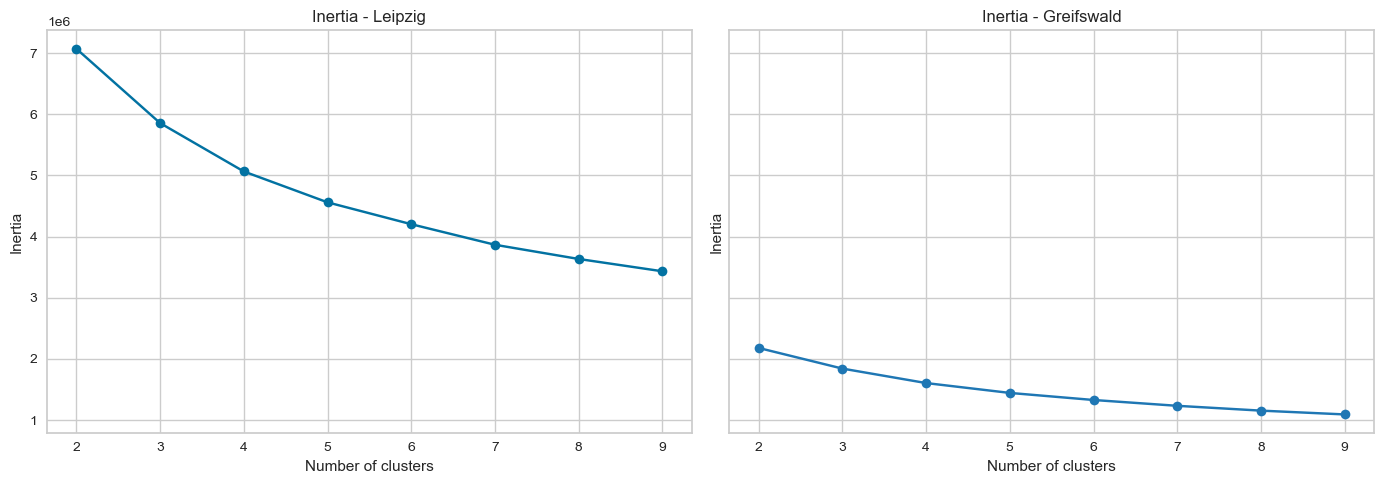

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Intertia for Liepzig
axes[0].plot(cluster_range, inertia_values_leipzig, marker='o')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Inertia - Leipzig')


# Inertia for Greifswald
axes[1].plot(cluster_range, inertia_values_greifswald, marker='o', color='tab:blue')
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Inertia - Greifswald')


# Show the plots
plt.tight_layout()
plt.show()

Inertia/ distortion is the sum of squared distance between the data point to the center of the cluster/centroid.
Lower intertia indicates that the data is clustered more tightly around the centroid. 
Inertia tends to decrease on its own as the number of clusters increases.

The interia above is steadily decreasing as the number of clusters increases, which is to be expected. 
There isn't a really obvious elbow here in the data for either medical center. 

Hopefully the additional clustering metrics below will be more helpful.  

## <a id='toc4_2_'></a>[Davies Bouldin Score](#toc0_)

In [18]:
cluster_range = range(2, 10)
dbi_scores_leipzig = []

# Calculate inertia for different numbers of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(leipzig_full_data_num_scaled)
    labels = kmeans.labels_
    dbi_score = davies_bouldin_score(leipzig_full_data_num_scaled, labels)
    dbi_scores_leipzig.append(dbi_score)


In [19]:
cluster_range = range(2, 10)
dbi_scores_greifswald = []

# Calculate inertia for different numbers of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(greifswald_full_data_num_scaled)
    labels = kmeans.labels_
    dbi_score = davies_bouldin_score(greifswald_full_data_num_scaled, labels)
    dbi_scores_greifswald.append(dbi_score)

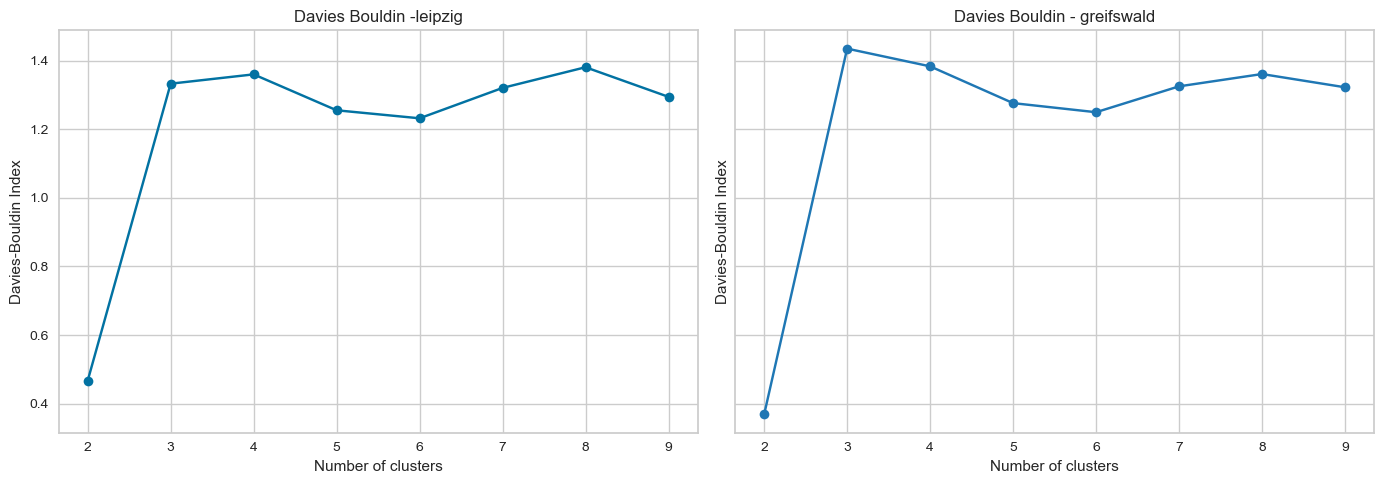

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Intertia for Liepzig
axes[0].plot(cluster_range, dbi_scores_leipzig, marker='o')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Davies-Bouldin Index')
axes[0].set_title('Davies Bouldin -leipzig')

# Inertia for Greifswald
axes[1].plot(cluster_range, dbi_scores_greifswald, marker='o', color='tab:blue')
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies Bouldin - greifswald')

# Show the plots
plt.tight_layout()
plt.show()

DBI is a measure of how compact and separated the clusters are, with lower values indicating better clustering. 

Based on the above, there is clearly better clustering at 2 clusters for both medical centers. 

## <a id='toc4_3_'></a>[Calinski harabasz - Leipzig](#toc0_)

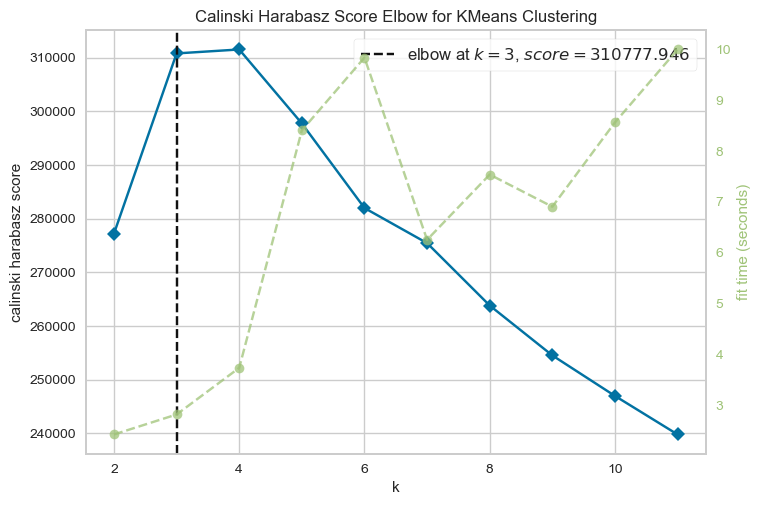

In [21]:
#Instantiate the model and visualizer
model_calinski_harabasz = KMeans(random_state=42)
visualizer_calinski_harabasz = KElbowVisualizer(model_calinski_harabasz, k=(2,12), metric = 'calinski_harabasz')

# Fit the data to the visualizer and render the figure
visualizer_calinski_harabasz.fit(leipzig_full_data_num_scaled)       
visualizer_calinski_harabasz.show();   

The Calinski-Harabasz score gives the ratio of between-cluster variance to within-cluster variance. A higher score indicates that the clusters are better defined and separated.
For the Leipzig center the elbow is being indicated as 3 clusters. 4 clusters has a slightly higher score, but 3 is where
the yellowbricks module is indicating diminishing returns from increasing cluster size. 

## <a id='toc4_4_'></a>[Calinski harabasz - Greifswald](#toc0_)

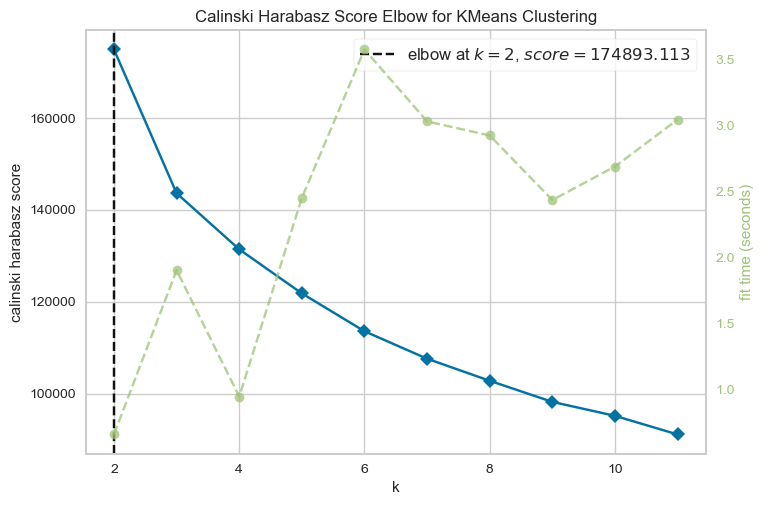

In [22]:
model_calinski_harabasz = KMeans(random_state=42)
visualizer_calinski_harabasz = KElbowVisualizer(model_calinski_harabasz, k=(2,12), metric = 'calinski_harabasz')

# Fit the data to the visualizer and render the figure
visualizer_calinski_harabasz.fit(greifswald_full_data_num_scaled)
visualizer_calinski_harabasz.show(); 

A different result on this metric for the Greifswald center. This is indicating 2 clusters as having the best separation. 

## <a id='toc4_5_'></a>[Silhouette](#toc0_)

The final metric for choosing a K here will be the Silhouette score. Computing this score is a lengthy process and 
is being done using a separate notebook in Colab Pro. The results of that notebook will be imported here for display and
analysis. 

In [23]:
#calculate the scores for Greifswald - The data for that center is small enough to make it work in this notebook

k_values = [2,3,4,5,6]

silouette_avgs_griefswald = []

for k in k_values:
  model_silhouette = KMeans(n_clusters = k, random_state = 42)
  model_silhouette.fit(greifswald_full_data_num_scaled)
  labels = model_silhouette.labels_

  silhouette_avg = silhouette_score(greifswald_full_data_num_scaled, labels)
  silouette_avgs_griefswald.append(silhouette_avg)

In [24]:
print(silouette_avgs_griefswald)

[0.9399650617459178, 0.16148835819819454, 0.1779953305111109, 0.1799467539251629, 0.1869830369411074]


In [25]:
#The below imported from the colab notebook
leipzig_sillouette_scores = [0.9321617226875288, 0.19270528121177674, 0.21265608089081336, 0.20834510234974588]

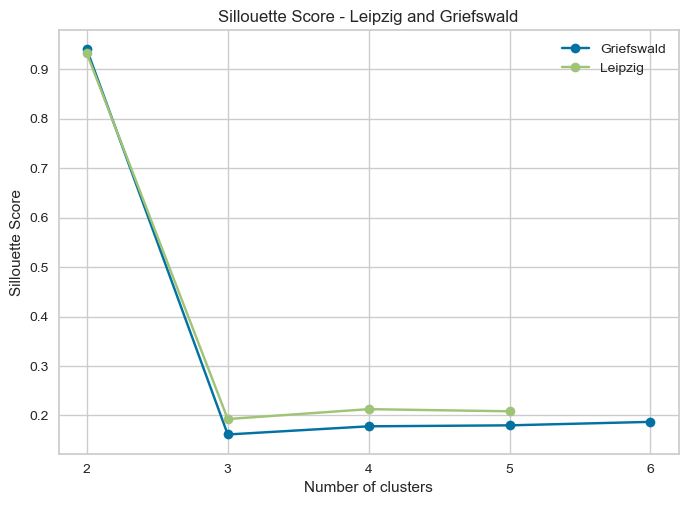

In [26]:
plt.plot([2,3,4,5,6], silouette_avgs_griefswald, marker='o', label = 'Griefswald')
plt.plot([2,3,4,5], leipzig_sillouette_scores , marker='o',  label = 'Leipzig')


plt.xticks([2,3,4,5,6])

plt.xlabel('Number of clusters')
plt.ylabel('Sillouette Score')
plt.title('Sillouette Score - Leipzig and Griefswald')
plt.legend()


plt.show()

The silhouette score ranges from -1 to 1, with 1 indicating strong clustering and -1 indicating poor clustering.

Nothing ambiguous here, 2 clusters are clearly indicated. The scores for both medical centers are in the upper 90s, indicating very strong clustering when 2 clusters are used.

Most of the metrics here are indicating two clusters, which matches with the number of classes in the problem as well. 
Below I'll explore the characterisitcs of the two clusters on the Leipzig data - it's the larger data set by far. 

# <a id='toc5_'></a>[Kmeans 2 clusters - Leipzig](#toc0_)

## <a id='toc5_1_'></a>[Train Model](#toc0_)

In [27]:
kmeans_k_2_leipzig = KMeans(n_clusters = 2, random_state = 42)
kmeans_k_2_leipzig.fit(leipzig_full_data_num_scaled)

KMeans(n_clusters=2, random_state=42)

## <a id='toc5_2_'></a>[Extract and append cluster labels](#toc0_)

In [28]:
kmeans_k_2_labels = pd.DataFrame(kmeans_k_2_leipzig.labels_, columns =['Kmeans_Group'])

In [29]:
leipzig_full_data_labeled = pd.concat([leipzig_full_data_df,kmeans_k_2_labels],axis = 1)
leipzig_full_data_labeled.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu,Kmeans_Group
0,1,79,M,Control,Leipzig,Training,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,Control,NaN,0
1,2,35,M,Control,Leipzig,Training,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,Control,NaN,0
2,3,47,W,Control,Leipzig,Training,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,Control,NaN,0
3,4,28,M,Control,Leipzig,Training,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,Control,NaN,0
4,5,63,W,Control,Leipzig,Training,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,Control,NaN,0


## <a id='toc5_3_'></a>[Label Analysis for k = 2](#toc0_)

Will the clustering done by Kmeans separate the classes we know we have in a meaningful way? 

In [30]:
leipzig_full_data_labeled['Kmeans_Group'].value_counts()

Kmeans_Group
0    1380531
1        827
Name: count, dtype: int64

Definiitely some class imbalance reflected here. There are fewer points in cluster 1 than there
are cases labeled as Sepsis in the data. How many of the cluster 1 group are actually Labeled as Sepsis in the data. 

In [31]:
#Seaparate the Kmeans groups into their own dataframes

k_2_group_0 = leipzig_full_data_labeled[leipzig_full_data_labeled['Kmeans_Group']==0]
k_2_group_1 = leipzig_full_data_labeled[leipzig_full_data_labeled['Kmeans_Group']==1]

In [32]:
k_2_group_0['Label'].value_counts()

Label
Control    1378530
Sepsis        2001
Name: count, dtype: int64

In [33]:
k_2_group_1['Label'].value_counts()

Label
Control    812
Sepsis      15
Name: count, dtype: int64

Looks like the cases are pretty jumbled up here. The minority label is still moslty cases labeled as control. 
And the majority label contains most of the cases labeled as Sepsis. 

So what is separating these two groups? 

In [34]:

all_columns = ['Age','Sex','Diagnosis','Center','Time','SecToIcu','CRP','HGB','MCV','PCT','PLT','RBC','WBC','Label','HrsToIcu']
num_columns  = ['Age','Time','SecToIcu','CRP','HGB','MCV','PCT','PLT','RBC','WBC','HrsToIcu']
cat_columns = ['Sex','Diagnosis','Center','Label']

k_2_group_0_dict = {}
k_2_group_1_dict = {}

#Find stats for Cluster 0
for col in all_columns:
    if col in num_columns:
        k_2_group_0_dict[col] = k_2_group_0[col].mean()
        k_2_group_1_dict[col] = k_2_group_1[col].mean()
    
    if col in cat_columns:
        value_counts_0 = k_2_group_0[col].value_counts(normalize=True) * 100
        for value in value_counts_0.index:
            percentage = round(value_counts_0[value], 1)
            k_2_group_0_dict[f'{col}_{value}'] = f'Group is {percentage}% {value}'

        value_counts_1 = k_2_group_1[col].value_counts(normalize=True) * 100
        for value in value_counts_1.index:
            percentage = round(value_counts_1[value], 1)
            k_2_group_1_dict[f'{col}_{value}'] = f'Group is {percentage}% {value}'


        


In [36]:
for key, value in k_2_group_0_dict.items():
    print(f'{key}:')

    if key in num_columns:
        print(f'Group 0 - Mean value {k_2_group_0_dict[key]}')
        print(f'Group 1 - Mean value {k_2_group_1_dict[key]}')
        print('\n')

    else:
        print(f'Group 0 - {k_2_group_0_dict[key]}')
        print(f'Group 1 - {k_2_group_1_dict[key]}')
        print('\n')

Age:
Group 0 - Mean value 57.06470843465304
Group 1 - Mean value 65.03264812575574


Sex_W:
Group 0 - Group is 50.3% W
Group 1 - Group is 31.7% W


Sex_M:
Group 0 - Group is 49.7% M
Group 1 - Group is 68.3% M


Diagnosis_Control:
Group 0 - Group is 98.8% Control
Group 1 - Group is 91.5% Control


Diagnosis_Sepsis:
Group 0 - Group is 1.2% Sepsis
Group 1 - Group is 8.5% Sepsis


Center_Leipzig:
Group 0 - Group is 100.0% Leipzig
Group 1 - Group is 100.0% Leipzig


Time:
Group 0 - Mean value 743381.1740265159
Group 1 - Mean value 439805.80411124544


SecToIcu:
Group 0 - Mean value 713617.1672799755
Group 1 - Mean value 701364.5454545454


CRP:
Group 0 - Mean value 30.022550325100237
Group 1 - Mean value 48.363136882129275


HGB:
Group 0 - Mean value 7.534179601906797
Group 1 - Mean value 5.782466747279322


MCV:
Group 0 - Mean value 88.0839443663344
Group 1 - Mean value 91.30024183796857


PCT:
Group 0 - Mean value 1.645109783797425
Group 1 - Mean value 6.315384615384615


PLT:
Group 0 - M

There are some differences here between the groups that stand out. 

The most obvious differences are for the values for:
- Sepsis Diagnosis - Group 1 contains 7 times more sepsis diagnosis cases
- PCT - Group 1 average PCT values are about 4x higher
- PLT - Group 1 average PLT values are about 30% less than Group 0
- WBC - Group 1 avererage WBC values are almost 23x those of Group 0 
- Sepsis Label: The percentage of Labeled Sepsis Cases in Group 1 is 8x higher than group 0

There are also smaller differences in 
- Age - 57 vs. 65
- Sex - Group 1 has 19% more men than Group 0


All that being said, the imbalance in classes here is playing a major role. Group 1 seems to contain more Sepsis cases as a percentage, 
but Group 1 is also less than 100 cases, while Group 0 is over 130,000 and actually contains over 100x more cases labled Sepsis than Group 0.

The difference in Sepsis diagnosis vs. Sepsis Label is particularly interesting. Are the Sepsis Diagnosis cases the same as the Sepsis labeled cases in Group 1, 
or are some of the Sepsis diagnosis cases labeled as contorl because of the default 6 hour time window?

In [37]:
#k_2_group_0
#k_2_group_1

group_1_control_cases = k_2_group_1[k_2_group_1['Label']=='Control']
group_1_control_cases['Diagnosis'].value_counts()

Diagnosis
Control    757
Sepsis      55
Name: count, dtype: int64

In [38]:
group_1_sepsis_control = group_1_control_cases[group_1_control_cases['Diagnosis']=='Sepsis']
group_1_sepsis_control_under_100_hours = group_1_sepsis_control[group_1_sepsis_control['HrsToIcu']<= 72]

print(f'There are {len(group_1_sepsis_control_under_100_hours)} cases in group 1 labeled as control that are Sepsis cases within 72 hours of ICU admission')


There are 20 cases in group 1 labeled as control that are Sepsis cases within 72 hours of ICU admission


So there are an additional 55 cases in Group_1 with a diagnosis of Sepsis but that are labeled as control. 
That's reflected above in that 8.5% of the cases in Group_1 have a Sepsis diagnosis, but only 1.8% were labeled as Sepsis due to being within the 6 hour window. 
Some of those cases are months and months from the ICU, but 20 of those cases are within 72 hours of ICU admission.

What about the larger cluster, Group_0? Is the same pattern present there? 

In [39]:
group_0_control_cases = k_2_group_0[k_2_group_0['Label']=='Control']
group_0_control_cases['Diagnosis'].value_counts()

Diagnosis
Control    1363947
Sepsis       14583
Name: count, dtype: int64

In [40]:
group_0_sepsis_control = group_0_control_cases[group_0_control_cases['Diagnosis']=='Sepsis']
group_0_sepsis_control_under_100_hours = group_0_sepsis_control[group_0_sepsis_control['HrsToIcu']<= 72]

print(f'There are {len(group_0_sepsis_control_under_100_hours)} cases in group 1 labeled as control that are Sepsis cases within 72 hours of ICU admission')

There are 2716 cases in group 1 labeled as control that are Sepsis cases within 72 hours of ICU admission


Yes, looks like the same thing. There are large numbers of blood tests from people who did get sepsis that are outside the 
6 hour window, and are not therefore labeled as Sepsis in the data. In this case, there are 2716 cases with a sepsis diagnosis and blood tests within 72 hours
that are labeled as control. 

The 6 hour window was chosen by the publishers based on their 
project, but it's not necessarily optimal in terms of model building. 

This could be important, and will be explored more below. 

# <a id='toc6_'></a>[KMeans - Sample Weight Adjustment](#toc0_)

The differences in the clusters here are based on both classes having equal weights. The classes are very very imbalanced. 
I wonder if we might tweak the model to better address the class imbalance by using the KMeans sample weights parameter. 

In this section I'll adjust the sample weights to see how it affects the clustering behavior at K=2.
First a quick check to be sure that the default settings (n_iter = 300) resulted in full convergence.

In [41]:
#Check how many iterations the algorithm used 
print(f'Number of iterations: {kmeans_k_2_leipzig.n_iter_}')

Number of iterations: 19


The model stopped well before the number of maximum iterations, indicating that there is no issue with not reaching convergence. 

In [42]:
#Define a function to check how many cases labeled Sepsis are in each cluster.

def check_sepsis_labels(df, cluster_col, label_col, label):
    '''
    This function takes a data frame with two cluster labels, separates it into the differen clusters
    and returns the percentage of each cluster that has a specific label. Percentages are rounded to 2 places

    Parameters:
    df = a dataframe with a column indicating which cluster group each row belongs to.
    cluster_col = A string, corresponding to the name of the column containing the cluster group labels
    label_col = A string, corresponding to the name of the column containing labels to be measured
    label = A string, corresponding to the label being measured in each cluster. 

    The function returns a dictonary containing the size of each cluster and the percentage of the cluster
    where the value in the label_col matches the label parameter
    '''
    
    group_0 = df[df[cluster_col]==0]
    group_0_size = (len(group_0))
    group_0_label_size = len(group_0[group_0[label_col]==label])
    group_0_label_percent =  round((group_0_label_size/group_0_size)*100,2)
    


    group_1 = df[df[cluster_col]==1]
    group_1_size = (len(group_1))
    group_1_label_size = len(group_1[group_1[label_col]==label])
    group_1_label_percent =  round((group_1_label_size/group_1_size)*100,2)

    values_dict = {'group_0_size':group_0_size,
                   'group_0_label_size':group_0_label_size,
                   'group_0_label_percent':group_0_label_percent,

                   'group_1_size':group_1_size,
                   'group_1_label_size':group_1_label_size,
                   'group_1_label_percent': group_1_label_percent
                     }
    
    return values_dict






In [43]:
test = check_sepsis_labels(leipzig_full_data_labeled,'Kmeans_Group','Label','Sepsis')

In [ ]:
for key,value in test.items():
    print(key,':', value)

All matches with the numbers from the model made above, looks like the function is working pretty well. 

In [44]:
#Define a function to add different sample weights to the data

def make_sample_weights(df,label_col, label_1, label_1_weight, label_2_weight):
    '''
    This function takes a dataframe and creates an array of weights based on the values in
    a specific column. The function assumes that there are two different values to be weighted

    Parameters: 
    df = A dataframe containing the appropriate label_col
    label_col = A string, corresponding to the name of the column containing labels to be weighted
    label_1 = The value in label_col to be weighted
    label_1_weight = the weight to give label one
    label_2_weight = the weight to give label two.     
    '''

    #Create a new column of weights in the dataframe
    df['weights'] = np.where(df[label_col] == label_1, label_1_weight, label_2_weight)

    ## Extract the 'weights' column
    weights_array = df['weights'].values

    return weights_array

In [45]:
#Do this for undersampling and for over sampling?

#Loop through a grid space of various weights. -

weight_list = [[1,1],[2,1],[5,1],[10,1],[20,1],[100,1],[1000,1],[10000,1],[100000,1],[1000000,0.5],[1,0.5],[1,0.2],[1,0.1],[1,0.01],[1,0.001],[1,0.0001],[2,0.00001]]
results_dict = {}
iteration = 0


for weight in weight_list:
    iteration += 1
#Generate the weights using (make_sample_weights)    
    weights_array = make_sample_weights(leipzig_full_data_df,'Label','Sepsis',weight[0],weight[1])


#train the model using the wights array
    model = KMeans(n_clusters = 2, random_state = 42)
    model.fit(leipzig_full_data_num_scaled,sample_weight=weights_array)


    model_labels_df = pd.DataFrame(model.labels_, columns =['Kmeans_Group'])
    full_data_labeled = pd.concat([leipzig_full_data_df,model_labels_df],axis = 1)


    results_dict[iteration] = check_sepsis_labels(full_data_labeled, 'Kmeans_Group', 'Label', 'Sepsis')
    


In [46]:
for key, value in results_dict.items():
    print(key,':',value)

1 : {'group_0_size': 1380531, 'group_0_label_size': 2001, 'group_0_label_percent': 0.14, 'group_1_size': 827, 'group_1_label_size': 15, 'group_1_label_percent': 1.81}
2 : {'group_0_size': 1380535, 'group_0_label_size': 2001, 'group_0_label_percent': 0.14, 'group_1_size': 823, 'group_1_label_size': 15, 'group_1_label_percent': 1.82}
3 : {'group_0_size': 1380593, 'group_0_label_size': 2001, 'group_0_label_percent': 0.14, 'group_1_size': 765, 'group_1_label_size': 15, 'group_1_label_percent': 1.96}
4 : {'group_0_size': 1380649, 'group_0_label_size': 2002, 'group_0_label_percent': 0.15, 'group_1_size': 709, 'group_1_label_size': 14, 'group_1_label_percent': 1.97}
5 : {'group_0_size': 1380701, 'group_0_label_size': 2002, 'group_0_label_percent': 0.14, 'group_1_size': 657, 'group_1_label_size': 14, 'group_1_label_percent': 2.13}
6 : {'group_0_size': 1380849, 'group_0_label_size': 2005, 'group_0_label_percent': 0.15, 'group_1_size': 509, 'group_1_label_size': 11, 'group_1_label_percent': 2.16

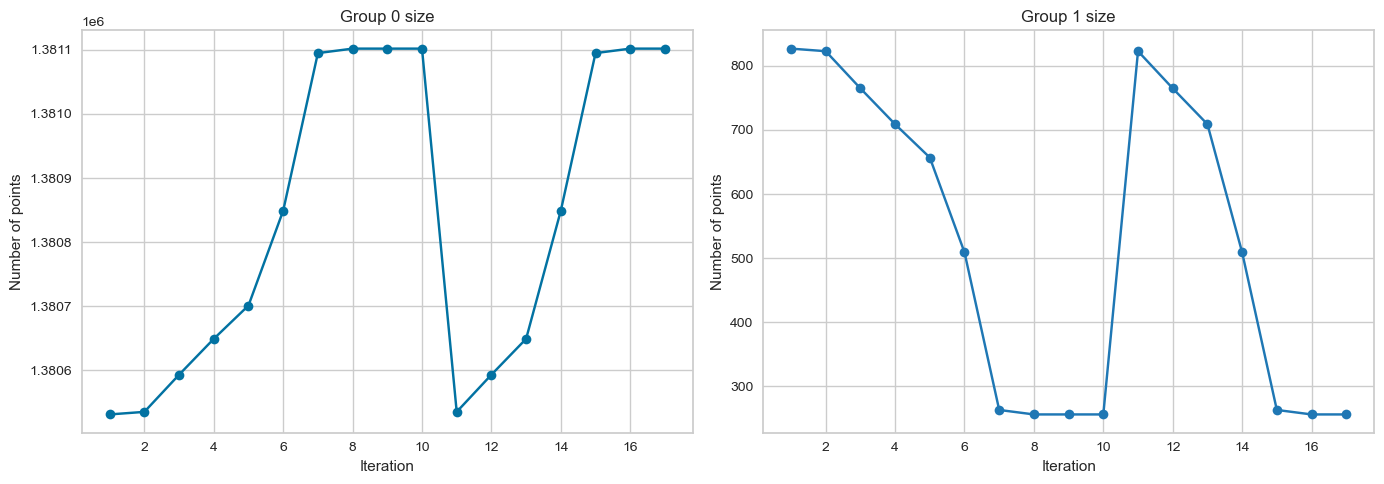

In [47]:
iteration = []
group_0_size = []
group_1_size = []

for key in results_dict.keys():
    iteration.append(key)
    group_0_size.append(results_dict[key]['group_0_size'])
    group_1_size.append(results_dict[key]['group_1_size'])


fig, axes = plt.subplots(1, 2, figsize=(14, 5),)

# Intertia for Liepzig
axes[0].plot(iteration, group_0_size, marker='o')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Number of points')
axes[0].set_title('Group 0 size')


# Inertia for Greifswald
axes[1].plot(iteration, group_1_size, marker='o', color='tab:blue')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Number of points')
axes[1].set_title('Group 1 size')

# Show the plots
plt.tight_layout()
plt.show()

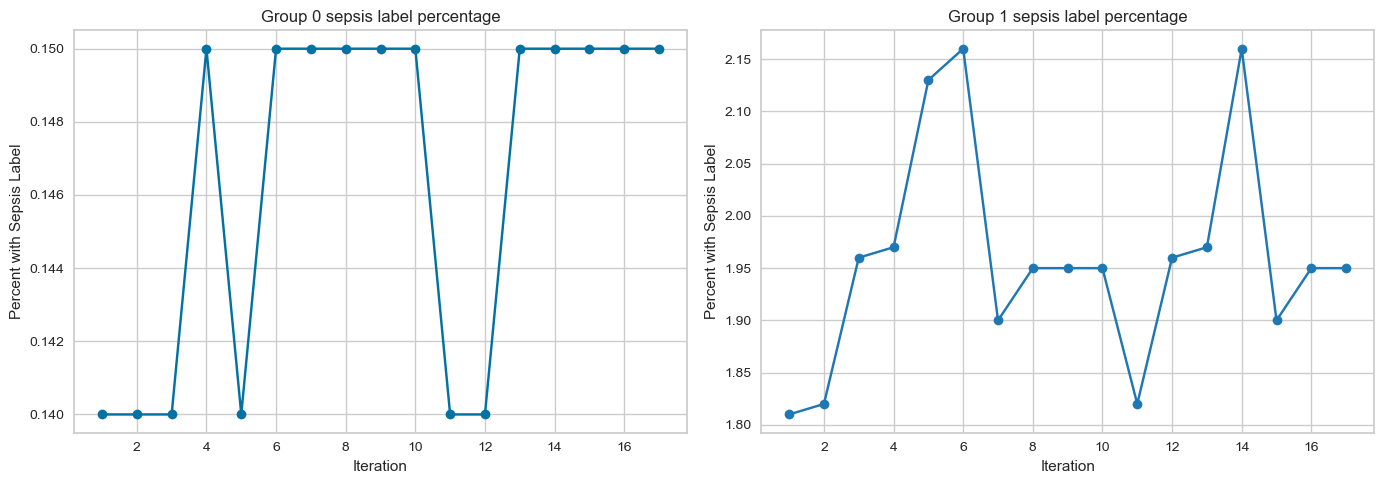

In [48]:
iteration = []
group_0_percent = []
group_1_percent = []

for key in results_dict.keys():
    iteration.append(key)
    group_0_percent.append(results_dict[key]['group_0_label_percent'])
    group_1_percent.append(results_dict[key]['group_1_label_percent'])


fig, axes = plt.subplots(1, 2, figsize=(14, 5),)

# Intertia for Liepzig
axes[0].plot(iteration, group_0_percent, marker='o')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Percent with Sepsis Label')
axes[0].set_title('Group 0 sepsis label percentage')


# Inertia for Greifswald
axes[1].plot(iteration, group_1_percent, marker='o', color='tab:blue')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Percent with Sepsis Label')
axes[1].set_title('Group 1 sepsis label percentage')

# Show the plots
plt.tight_layout()
plt.show()

Changing the sample weight does not appear to have a large effect. In iteration 8, with the Sepsis labled weighted at 10,000 and the 
control label at 1, there was an uptick in the percentage of the smaller cluster that was labeled as Sepsis. 
However, if you look at the actual numbers that make up that percent. It's clear that it's a result not of more sepsis cases being 
placed in the cluster. Instead, there are actually fewer cases in the cluster, but the cluster is also smaller. 
Even so, the numbers are not that different, 11 cases in iteration 8 vs. 15 for the default equal weighting.

Given the above, it seems that the clusters are pretty stable and well seaprated, which is consistent with the very high
sillouette score noted above for k = 2.

# <a id='toc7_'></a>[Feature Analysis for k = 2](#toc0_)

Below I'll look at each feature in the two clusters individually to better understand the differences between the two groups. 

## <a id='toc7_1_'></a>[Spider Chart for CBC Features](#toc0_)

In [49]:
k_2_group_0 = leipzig_full_data_labeled[leipzig_full_data_labeled['Kmeans_Group']==0]
k_2_group_1 = leipzig_full_data_labeled[leipzig_full_data_labeled['Kmeans_Group']==1]

In [50]:
k_2_group_0.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu,Kmeans_Group
0,1,79,M,Control,Leipzig,Training,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,Control,NaN,0
1,2,35,M,Control,Leipzig,Training,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,Control,NaN,0
2,3,47,W,Control,Leipzig,Training,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,Control,NaN,0
3,4,28,M,Control,Leipzig,Training,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,Control,NaN,0
4,5,63,W,Control,Leipzig,Training,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,Control,NaN,0


In [51]:
categories = ['HGB','MCV','PLT','RBC','WBC']

df_0_spider_chart = k_2_group_0 [categories]
df_1_spider_chart = k_2_group_1[categories]

In [52]:

df_0_spider_chart['MCV_scaled'] = df_0_spider_chart['MCV'] /10
df_0_spider_chart['PLT_scaled'] = df_0_spider_chart['PLT'] /10
df_0_spider_chart['WBC_scaled'] = df_0_spider_chart['WBC'] /10

df_1_spider_chart['MCV_scaled'] = df_1_spider_chart['MCV'] /10
df_1_spider_chart['PLT_scaled'] = df_1_spider_chart['PLT'] /10
df_1_spider_chart['WBC_scaled'] = df_1_spider_chart['WBC'] /10


categories_scaled = ['HGB','MCV_scaled','PLT_scaled','RBC','WBC_scaled']

/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_71386/2435323077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0_spider_chart['MCV_scaled'] = df_0_spider_chart['MCV'] /10
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_71386/2435323077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0_spider_chart['PLT_scaled'] = df_0_spider_chart['PLT'] /10
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_71386/2435323077.py:3: SettingWithCopyWarning: 
A value is trying to be

In [53]:
df_0_mean_values = []
df_0_median_values = []
df_1_mean_values =[]
df_1_median_values = []


for item in categories_scaled:
    df_0_mean_values.append(df_0_spider_chart[item].mean())
    df_0_median_values.append(df_0_spider_chart[item].median())
    df_1_mean_values.append(df_1_spider_chart[item].mean())
    df_1_median_values.append(df_1_spider_chart[item].median())

In [54]:
df_0_mean_values.append(df_0_mean_values[0])
df_1_mean_values.append(df_1_mean_values[0])

df_0_median_values.append(df_0_median_values[0])
df_1_median_values.append(df_1_median_values[0])

#print the mean and median values to see if there is a meaningful difference. There doesn't appear to be.
print(df_1_mean_values)
print(df_1_median_values)

[5.782466747279322, 9.130024183796856, 17.119226118500602, 3.1467593712212816, 18.198802902055622, 5.782466747279322]
[5.6, 9.040000000000001, 10.5, 3.06, 14.74, 5.6]


In [55]:
# Number of variables
num_vars = len(categories_scaled)

# Create a DataFrame for plotting
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values_0 = df_0_mean_values
values_1 = df_1_mean_values

angles += angles[:1]

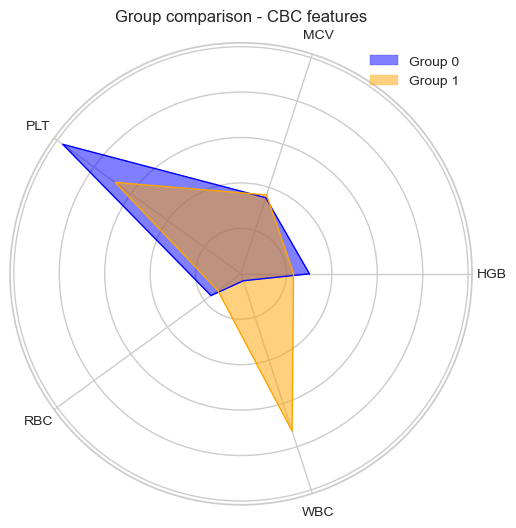

In [56]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values_0, color='blue', alpha=0.5,label= 'Group 0')
ax.plot(angles, values_0, color='blue', linewidth=1)

ax.fill(angles, values_1, color='orange', alpha=0.5,label= 'Group 1')
ax.plot(angles, values_1, color='orange', linewidth=1)


# Add labels
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)


#Add Title
plt.title('Group comparison - CBC features')

# Show the plot
plt.legend()
plt.show()

Some obvious differences here. The smaller cluster (group 1) has a lower mean PLT and a significantly higher mean WBC value. 
The WBC value in particular seems significant, because a high WBC value is associated with the body fighting infecitons. 
It can also be associated with other blood or bone marrow disorders, but we have not way to filter out cases that may have had conditions 
like that based on the data provided. 

Even with the stark difference here in Group 1, only a few of the cases in that Group are labeled as Sepsis. In fact, group 0 had many more Sepsis cases numbmerically, 
it just also has a lot more control cases. 

One explanaiton of this patter above might be that the clustering is separating the cases based largely on the WBC scores.
But not all cases which have a high WBC score end up developing sepsis as a condition. THe WB indicates and infection, but not necessarily Sepsis. 

## <a id='toc7_2_'></a>[Spider Chart for CBC Features + Sepsis](#toc0_)

To get a better idea of how the cases labeled as Sepsis compare to the Groups. I'll overlay the data from the clusters
with data from all the cases labeled Sepsis.

In [57]:
leipzig_all_sepsis_cases = leipzig_full_data_df[leipzig_full_data_df['Label']=="Sepsis"]


categories = ['HGB','MCV','PLT','RBC','WBC']

sepsis_spider_chart = leipzig_all_sepsis_cases[categories]


sepsis_spider_chart['MCV_scaled'] = df_0_spider_chart['MCV'] /10
sepsis_spider_chart['PLT_scaled'] = df_0_spider_chart['PLT'] /10
sepsis_spider_chart['WBC_scaled'] = df_0_spider_chart['WBC'] /10


sepsis_spider_chart_mean_values = []
sepsis_spider_chart_median_values = []


for item in categories_scaled:
    sepsis_spider_chart_mean_values.append(sepsis_spider_chart[item].mean())
    sepsis_spider_chart_median_values.append(sepsis_spider_chart[item].median())



sepsis_spider_chart_mean_values.append(sepsis_spider_chart_mean_values[0])
sepsis_spider_chart_median_values.append(sepsis_spider_chart_median_values[0])


#print the mean and median values to see if there is a meaningful difference. There doesn't appear to be.
print(sepsis_spider_chart_mean_values)
print(sepsis_spider_chart_median_values)

# Number of variables
num_vars = len(categories_scaled)

# Create a DataFrame for plotting
sepsis_angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values_sepsis = sepsis_spider_chart_mean_values

sepsis_angles += sepsis_angles[:1]

[6.968353174603175, 8.943623188405798, 21.56006996501749, 3.7911855158730154, 1.410279860069965, 6.968353174603175]
[7.0, 8.89, 19.9, 3.83, 1.28, 7.0]


/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_71386/1849675170.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_spider_chart['MCV_scaled'] = df_0_spider_chart['MCV'] /10
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_71386/1849675170.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_spider_chart['PLT_scaled'] = df_0_spider_chart['PLT'] /10
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_71386/1849675170.py:11: SettingWithCopyWarning: 
A value is trying

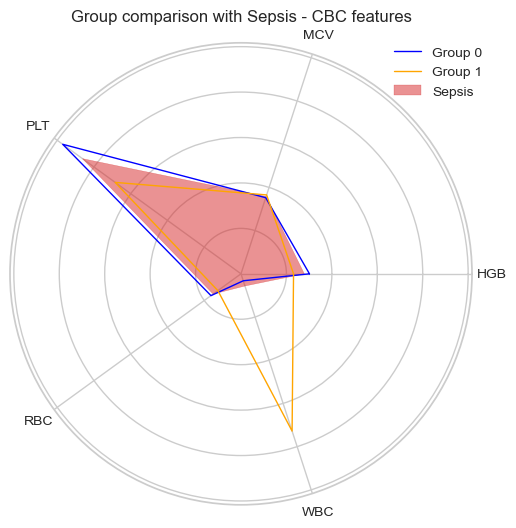

In [58]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
#ax.fill(angles, values_0, color='blue', alpha=0.5,label= 'Group 0')
ax.plot(angles, values_0, color='blue', linewidth=1,label= 'Group 0')

#ax.fill(angles, values_1, color='orange', alpha=0.5,label= 'Group 1')
ax.plot(angles, values_1, color='orange', linewidth=1,label= 'Group 1')

ax.fill(sepsis_angles, values_sepsis, color='tab:red', alpha=0.5,label= 'Sepsis')
#ax.plot(sepsis_angles, values_sepsis, color='orange', linewidth=1)

# Add labels
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)


#Add Title
plt.title('Group comparison with Sepsis - CBC features')

# Show the plot
plt.legend(loc ='upper right',bbox_to_anchor=(1.05, 1.02))
plt.show()

The Sepsis cases dont' follow the same pattern as the clustering does. The biggest difference between the clusters 
seems to be the higher average WBC counts. But the Sepsis cases have a very low average, almost all clustering 
within group 1, where the majority of all the control cases are as well.

This would not seem to bode well for being able to sucessfully separate the sepsis and control cases with KMeans clustering. 

To be sure, I'll break out each feature individually below. The spider charts here are based on mean values, and they look
about the same when the median is used as well. But measures of central tendancy are not the whole story. Maybe looking at the full 
distributions of each variable will provide more insight. 

# <a id='toc8_'></a>[Individual Feature Comparisions](#toc0_)

This and all of the feature comparisons below will use density for the histograms. 
This is necessary due to the difference in cluster sizes.

Before comparing the features, I'll need to define a couple functions to save some coding space. 

In [59]:
#This function will simplify the plotting of the side by side histogram and box plots


def plot_hist_and_boxplot(df_col_1, df_col_2, df_col_3, hist_title, hist_x_label, box_title, box_y_label):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot histogram
    axes[0].hist(df_col_1, bins=20,  alpha=0.7,color = 'tab:blue', label = 'Cluster 0', density = True)
    axes[0].hist(df_col_2, bins=20,  alpha=0.7,color = 'orange', label = 'Cluster 1', density = True)
    axes[0].hist(df_col_3, bins=20,  alpha=0.7,color = 'tab:red', label = 'Sepsis Label', density = True)


    axes[0].set_title(hist_title)
    axes[0].set_xlabel(hist_x_label)
    axes[0].set_ylabel('Frequency')

    axes[0].legend()

    #Plot Boxplot
    box_plot_data = [df_col_1, df_col_2,df_col_3]


# Labels for each group
    box_plot_labels = ['Cluster 0','Cluster 1','Sepsis Label']

# Creating the box plot with colors
    boxplot = axes[1].boxplot(box_plot_data, labels=box_plot_labels, patch_artist = True)

    box_colors = ['tab:blue','orange','tab:red']  # Colors for each box
    for i, box in enumerate(boxplot['boxes']):
        box.set(color='black', linewidth=2, alpha = 0.7)
        box.set(facecolor=box_colors[i])

# Adding title and labels
    axes[1].set_title(box_title)
    axes[1].set_ylabel(box_y_label)


    plt.tight_layout()

    plt.show()

In [60]:
#This function will simplify tests for statistical signifigance between clusters on a particular feature. 

def welches_t_test(group_0, group_1, group_0_name, group_1_name):
    
    # Perform an independent samples t-test
    t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)  # Use equal_var=True if you assume equal variances

    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    # Check if the result is statistically significant
    alpha = 0.05  # Common significance level
    if p_value < alpha:
        print(f"The difference between {group_0_name} and {group_1_name} is statistically significant.")
    else:
        print(f"The difference between {group_0_name} and {group_1_name} is not statistically significant.")

## <a id='toc8_1_'></a>[HGB comparison](#toc0_)

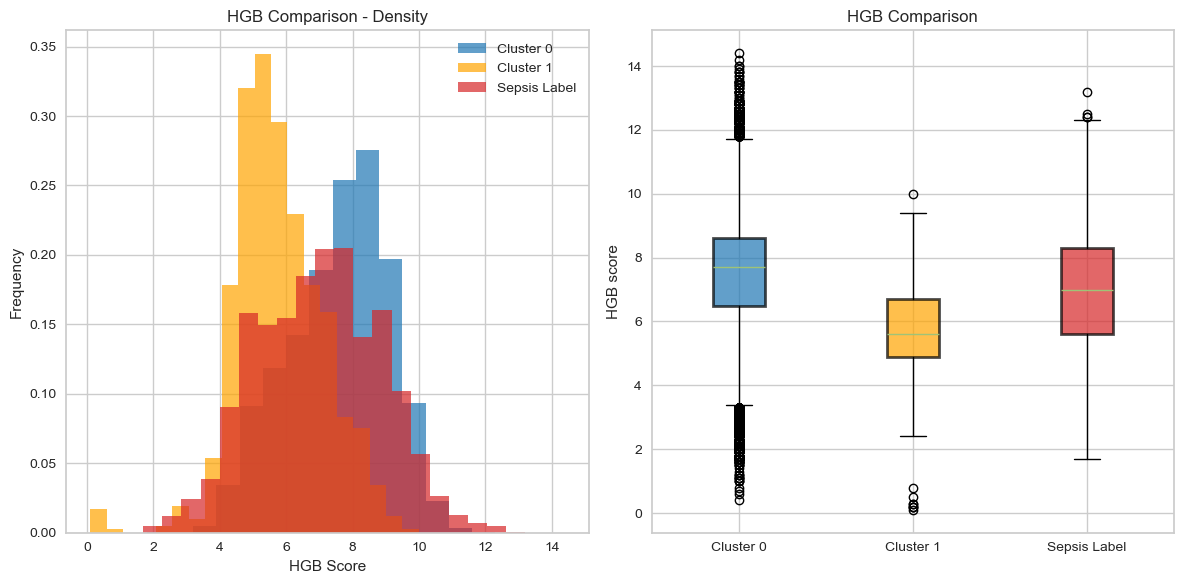

In [61]:
plot_hist_and_boxplot(k_2_group_0['HGB'],k_2_group_1 ['HGB'],leipzig_all_sepsis_cases['HGB'],'HGB Comparison - Density','HGB Score','HGB Comparison','HGB score')

In [62]:
welches_t_test(k_2_group_0['HGB'], k_2_group_1 ['HGB'], 'cluster 0 HGB', 'cluster 1 HGB')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['HGB'], k_2_group_1 ['HGB'], 'Sepsis cases HGB', 'cluster 1 HGB')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['HGB'], k_2_group_0 ['HGB'], 'Sepsis cases HGB', 'cluster 0 HGB')

T-statistic: 36.8846242692867
P-value: 7.128354884458069e-177
The difference between cluster 0 HGB and cluster 1 HGB is statistically significant.


T-statistic: 18.796619551956145
P-value: 6.443268653792829e-73
The difference between Sepsis cases HGB and cluster 1 HGB is statistically significant.


T-statistic: -13.61088185261053
P-value: 1.9814502475100743e-40
The difference between Sepsis cases HGB and cluster 0 HGB is statistically significant.


## <a id='toc8_2_'></a>[MCV comparison](#toc0_)

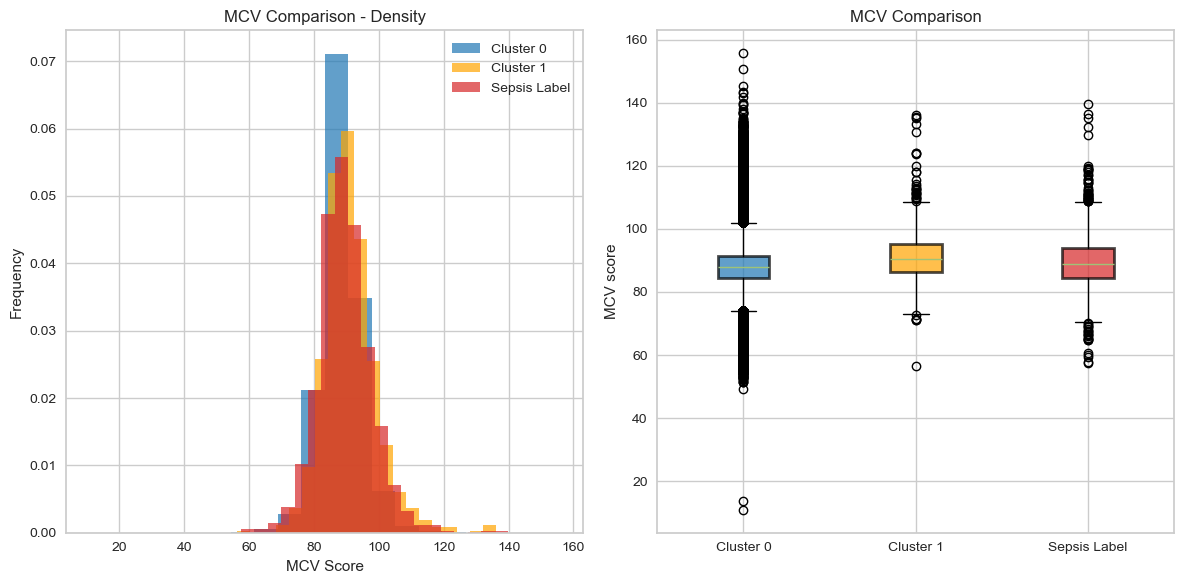

In [63]:
plot_hist_and_boxplot(k_2_group_0['MCV'],k_2_group_1 ['MCV'],leipzig_all_sepsis_cases['MCV'],'MCV Comparison - Density','MCV Score','MCV Comparison','MCV score')

In [64]:
welches_t_test(k_2_group_0['MCV'], k_2_group_1 ['MCV'], 'cluster 0 MCV', 'cluster 1 MCV')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['MCV'], k_2_group_1 ['MCV'], 'Sepsis cases MCV', 'cluster 1 MCV')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['MCV'], k_2_group_0 ['MCV'], 'Sepsis cases MCV', 'cluster 0 MCV')

T-statistic: -10.898608462892796
P-value: 6.170184062318187e-26
The difference between cluster 0 MCV and cluster 1 MCV is statistically significant.


T-statistic: -5.145211039050285
P-value: 3.017358513160858e-07
The difference between Sepsis cases MCV and cluster 1 MCV is statistically significant.


T-statistic: 7.508263818911552
P-value: 8.940093336967957e-14
The difference between Sepsis cases MCV and cluster 0 MCV is statistically significant.


## <a id='toc8_3_'></a>[PLT comparison](#toc0_)

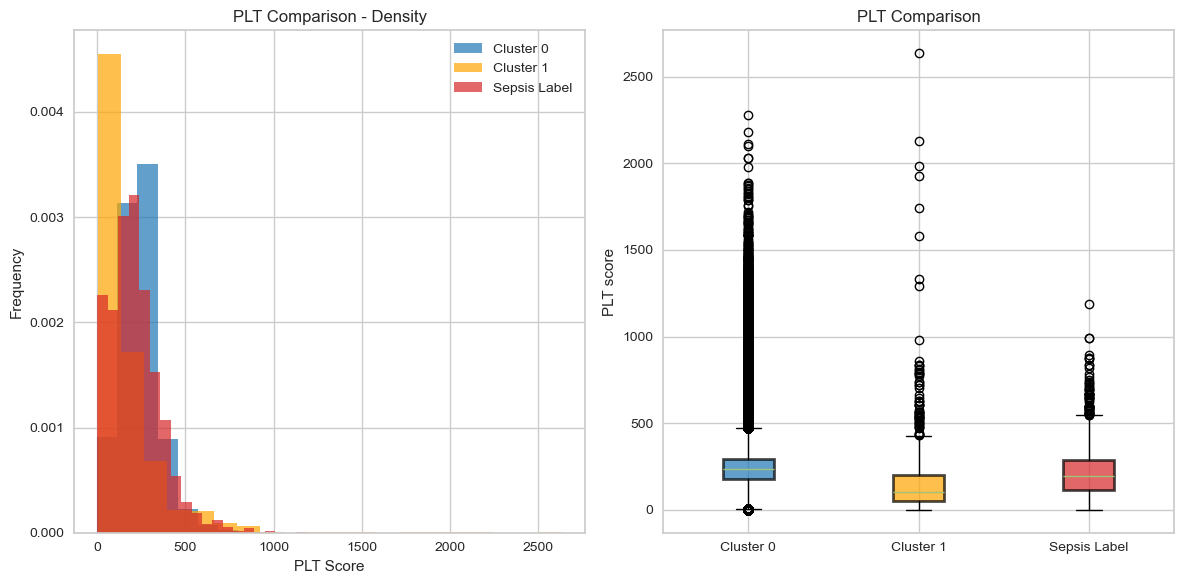

In [65]:
plot_hist_and_boxplot(k_2_group_0['PLT'],k_2_group_1 ['PLT'],leipzig_all_sepsis_cases['PLT'],'PLT Comparison - Density','PLT Score','PLT Comparison','PLT score')

In [66]:
welches_t_test(k_2_group_0['PLT'], k_2_group_1 ['PLT'], 'cluster 0 PLT', 'cluster 1 PLT')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['PLT'], k_2_group_1 ['PLT'], 'Sepsis cases PLT', 'cluster 1 PLT')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['PLT'], k_2_group_0 ['PLT'], 'Sepsis cases PLT', 'cluster 0 PLT')

T-statistic: 8.876701533378796
P-value: 4.218477979195023e-18
The difference between cluster 0 PLT and cluster 1 PLT is statistically significant.


T-statistic: 5.04210705079792
P-value: 5.379530538373366e-07
The difference between Sepsis cases PLT and cluster 1 PLT is statistically significant.


T-statistic: -8.569667982797661
P-value: 2.0280116415348312e-17
The difference between Sepsis cases PLT and cluster 0 PLT is statistically significant.


## <a id='toc8_4_'></a>[RBC comparison](#toc0_)

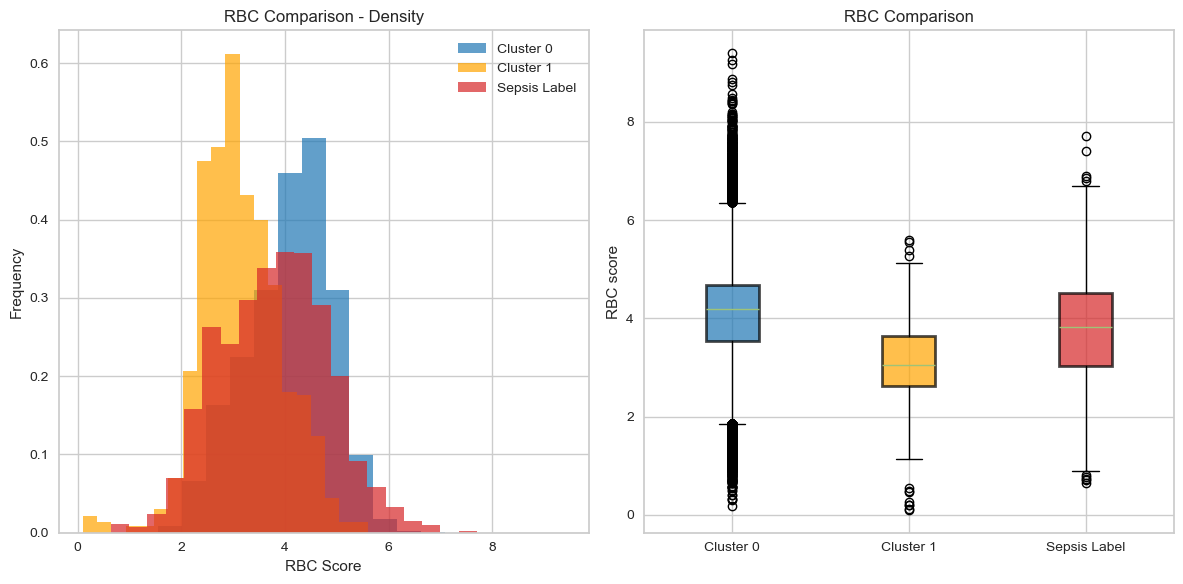

In [67]:
plot_hist_and_boxplot(k_2_group_0['RBC'],k_2_group_1 ['RBC'],leipzig_all_sepsis_cases['RBC'],'RBC Comparison - Density','RBC Score','RBC Comparison','RBC score')

In [68]:
welches_t_test(k_2_group_0['RBC'], k_2_group_1 ['RBC'], 'cluster 0 RBC', 'cluster 1 RBC')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['RBC'], k_2_group_1 ['RBC'], 'Sepsis cases RBC', 'cluster 1 RBC')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['RBC'], k_2_group_0 ['RBC'], 'Sepsis cases RBC', 'cluster 0 RBC')

T-statistic: 34.49839716369169
P-value: 2.7009113875866325e-162
The difference between cluster 0 RBC and cluster 1 RBC is statistically significant.


T-statistic: 18.002154310282528
P-value: 2.332944289529237e-67
The difference between Sepsis cases RBC and cluster 1 RBC is statistically significant.


T-statistic: -12.5506496978545
P-value: 7.603325855387617e-35
The difference between Sepsis cases RBC and cluster 0 RBC is statistically significant.


## <a id='toc8_5_'></a>[WBC comparison](#toc0_)

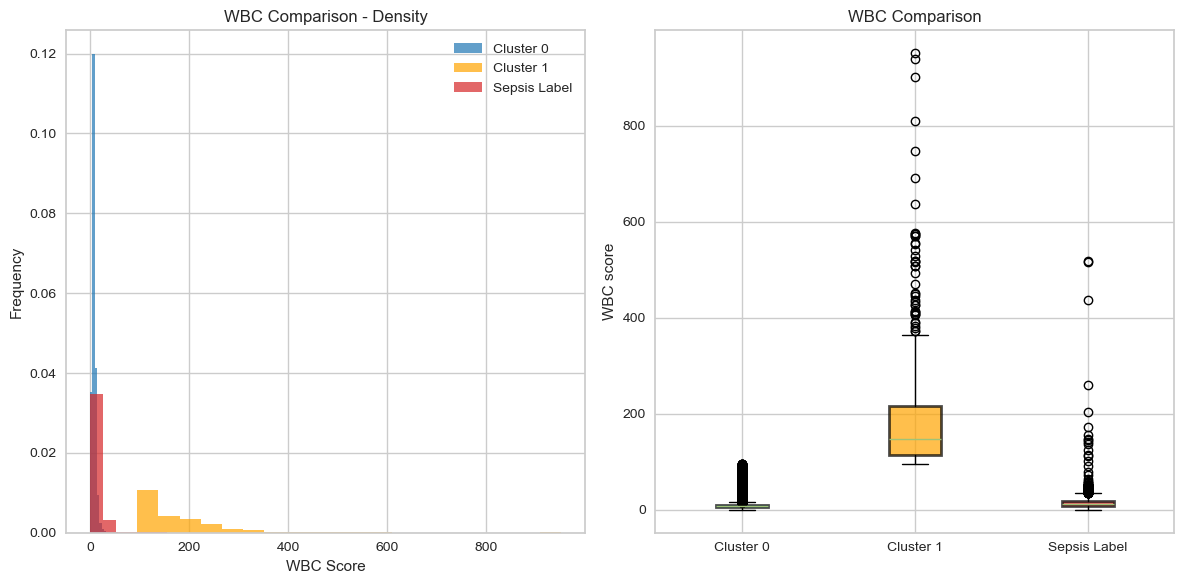

In [69]:
plot_hist_and_boxplot(k_2_group_0['WBC'],k_2_group_1 ['WBC'],leipzig_all_sepsis_cases['WBC'],'WBC Comparison - Density','WBC Score','WBC Comparison','WBC score')

In [70]:
welches_t_test(k_2_group_0['WBC'], k_2_group_1 ['WBC'], 'cluster 0 WBC', 'cluster 1 WBC')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['WBC'], k_2_group_1 ['WBC'], 'Sepsis cases WBC', 'cluster 1 WBC')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['WBC'], k_2_group_0 ['WBC'], 'Sepsis cases WBC', 'cluster 0 WBC')

T-statistic: -47.221778710777116
P-value: 7.274525680919733e-237
The difference between cluster 0 WBC and cluster 1 WBC is statistically significant.


T-statistic: -44.71687031929569
P-value: 1.503148503146675e-226
The difference between Sepsis cases WBC and cluster 1 WBC is statistically significant.


T-statistic: 14.445923026218239
P-value: 4.3862350812291154e-45
The difference between Sepsis cases WBC and cluster 0 WBC is statistically significant.


## <a id='toc8_6_'></a>[Feature comparisons Summary](#toc0_)

For all of the features above we see a similar pattern. The clusters overlap but have statistically significant differences. 
The distribution for the labeled sepsis data has significant overlaps with both, but is different from both as well. 

The only place this seems to be untrure is for the 'WBC' feature. Where there is very little overlap.
Even here however, the distributions are statisitically different.

What about the Sepsis and control cases, are these significantly different as well? 

In [71]:
leipzig_all_control_cases = leipzig_full_data_df[leipzig_full_data_df['Label']=="Control"]

In [72]:
welches_t_test(leipzig_all_sepsis_cases['HGB'], leipzig_all_control_cases['HGB'], 'Sepsis cases HGB', 'Control Cases HGB')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['MCV'], leipzig_all_control_cases['MCV'], 'Sepsis cases MCV', 'Control Cases MCV')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['PLT'], leipzig_all_control_cases['PLT'], 'Sepsis cases PLT', 'Control Cases PLT')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['RBC'], leipzig_all_control_cases['RBC'], 'Sepsis cases RBC', 'Control CasesRBC')
print('\n')
welches_t_test(leipzig_all_sepsis_cases['WBC'], leipzig_all_control_cases['WBC'], 'Sepsis cases WBC', 'Control Cases WBC')

T-statistic: -13.605507558057724
P-value: 2.1194827798044153e-40
The difference between Sepsis cases HGB and Control Cases HGB is statistically significant.


T-statistic: 7.509005292490539
P-value: 8.89097693983718e-14
The difference between Sepsis cases MCV and Control Cases MCV is statistically significant.


T-statistic: -8.56894037512208
P-value: 2.0404073767817748e-17
The difference between Sepsis cases PLT and Control Cases PLT is statistically significant.


T-statistic: -12.544905081247146
P-value: 8.132506103805558e-35
The difference between Sepsis cases RBC and Control CasesRBC is statistically significant.


T-statistic: 14.267543615708513
P-value: 4.525712532291722e-44
The difference between Sepsis cases WBC and Control Cases WBC is statistically significant.


The Sepsis and control cases distributions are different for all the features based on the analysis above. 
This is of course based on the Sepsis class being defined by the 6 hour window from ICU admission, which may be problematic. 

# <a id='toc9_'></a>[Summary](#toc0_)

Setting K at 2 for the Kmeans model is clearly indicated, especially by the very high silhouette score of 90+ for both medical centers. 

The clustering at K= 2 appears robust, even when sample weights are changed. The 2 clusters show differences in several features see “Label Analysis for k = 2” section. The differences here revealed a large disparity in the % of cases labeled as Sepsis vs. Diagnosed as Sepsis.

There was also a very large difference in WBC (white blood count readings) between the two clusters. 

Overall the clusters seem very distinct and generally well defined. However, the clustering does not seem to track well with the cases labeled as sepsis. The smaller group has a larger percentage of labeled Sepsis cases than the larger group, but the vast majority of Sepsis and control cases cluster in the larger group. To further complicate things, each cluster contains numerous cases labeled as “control” that have a Sepsis diagnosis. Some of these cases will be from blood tests that are months before ICU admission, but a significant number are within 72 hours of ICU admission. 

This mismatch between the labels based on the 6 hour window and the diagnosis feature could be significant.

The selection of the 6 hour window as a criteria for labeling a blood test as being in the Sepsis class causes a significant complication of the problem. It means that one of the classes is defined by two criteria, namely, a diagnosis of Sepsis and a blood test within 6 hours of ICU admission. That means the negative class is defined by either no sepsis diagnosis, or a sepsis diagnosis but no blood test within the 6 hour window. 

Given this structure, there are significant numbers of blood tests from people who got Sepsis that are labeled the same as blood tests from people who did not get Sepsis at all. The assumption would seem to be that blood tests outside a 6 hour window have much less or no utility in predicting the Sepsis. 

That assumption is likely justified in some way from the medical perspective of the publishers, but it may or may not be justified from a data science perspective. 

Based on this, it would seem that a different approach to the data structure, and possibly some additional feature engineering is needed. Those issues will be explored in another notebook. 